In [52]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [53]:
dog_org = Image.open("examples/dog.jpg")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
 )])
dog = transform(dog_org)

In [165]:
import torch
import numpy as np
import torch.nn.functional as F
from functools import partial


def gaussian_kernel(size=5, channels=3, sigma=1):
    ax = np.linspace(-(size - 1)/ 2., (size-1)/2., size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx)+ np.square(yy)) / np.square(sigma))
    kernel /= np.sum(kernel)
    kernel_tensor = torch.as_tensor(kernel, dtype=torch.float)
    kernel_tensor = kernel_tensor.repeat(channels, 1 , 1, 1)
    return kernel_tensor

def get_gaussian_blur_conv(kernel):
    channels = kernel.shape[0]
    padding = kernel.shape[-1] // 2
    gaussian_blur = partial(F.conv2d, weight=kernel, stride=1, padding=padding, groups=channels)
    return gaussian_blur


class PyramidImageLayer(nn.Module):
    def __init__(self, gaussian_size=5, init_sigma=1.6, pyramid_depth=3):
        super().__init__()
        self.weight = nn.Parameter(torch.rand((3, 224, 224), requires_grad=True))
        self.org_shape = self.weight.shape
        self.current_pyramid_level = 0
        self.gaussian_size = gaussian_size
        self.init_sigma = init_sigma
        self.pyramid_depth = pyramid_depth
        self.gaussian_blur = self._get_gaussian_blur()
    
    def _get_gaussian_blur(self):
        sigma = self.init_sigma * (2**self.current_pyramid_level)
        kernel = gaussian_kernel(size=self.gaussian_size, sigma=sigma)
        gaussian_blur = get_gaussian_blur_conv(kernel)
        return gaussian_blur
        
    def init_layer(self, image_batch):
        self.weight.data = image_batch[0, ...]
    
    def forward(self):
        return torch.unsqueeze(torch.mul(1, self.weight), 0)
    
    def go_pyramid(self):
        if self.current_pyramid_level >= self.pyramid_depth:
            return
        img = self.weight.data
        img_blurred = self.gaussian_blur(img)
        img_downsampled = img_blurred[:, ::2, ::2]
        self.weight = nn.Parameter(img_downsampled, requires_grad=True) # new parameters
        self.current_pyramid_level += 1
        self._get_gaussian_blur() # update gaussian blur function
    

In [166]:
pyramid = PyramidImageLayer()
pyramid.init_layer(torch.unsqueeze(dog, 0))

1.6


In [171]:
pyramid.go_pyramid()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


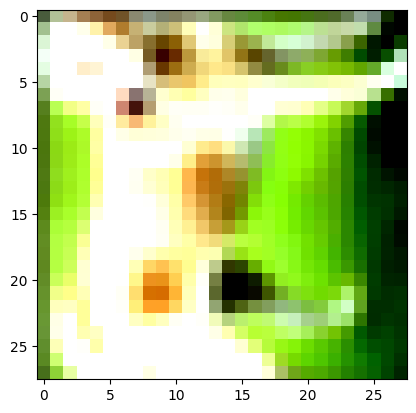

In [164]:
plt.imshow(pyramid.weight.detach().T)

In [119]:
blurred.shape

torch.Size([3, 224, 224])

In [116]:
blurred.shape

torch.Size([3, 224, 224])